# Esercitazione 1

In questa esercitazione il compito è quello di testare le prestazioni del generatore di numeri pseudo-casuali presente sul sito Ariel del corso, verificare la validità del Teorema del Limite Centrale e infine implementare una simulazione dell'esperimento di Buffon per la stima di $\pi$.

In [40]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.gridspec as gridspec
import scipy.stats as stats
from IPython.display import HTML

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [38]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<a href="javascript:code_toggle()">Mostra/Nascondi celle</a>.''')

### Esercizio1.1

Nel primo esercizio la richiesta è quella di testare il generatore di numeri pseudo-casuali fornitoci attraverso uno studio della media (A) e della varianza (B) delle variabili estratte ed un test del $\chi^2$ (C).

---
Poichè vengono utilizzati metodi numerici Monte Carlo dobbiamo effettuare il calcolo delle incertezze. A tal fine viene usato (da ora in avanti) il metodo del $data\,blocking$ che consiste nel suddividere le misurazioni della grandezza di interesse in $M$ blocchi per calcolarne successivamente la media separatamente per ogni blocco. Quest'ultima diventa l'unità effettiva sulla quale si basa la statistica. 
Il calcolo del valore di aspettazione finale si ottiene mediando gli output dei singoli blocchi, mentre la sua incertezza è la deviazione standard della media di questo insieme di risultati intermedi.
Naturalmente dobbiamo aspettarci che i risultati del $data\,blocking$ siano sempre più accurati col progressivo aumento del numero di blocchi utilizzati.

L'efficacia di questo metodo è dovuta a due fattori. Innanzitutto, se la taglia dei blocchi è sufficientemente grande, la correlazione delle misure all'interno del singolo blocco viene "confinata" ai bordi, e questo ci consente di usare la media di blocco come una variabile indipendente dalle altre medie. Se ciò accade, entra in gioco il secondo fattore, ossia il Teorema del Limite Centrale (TLC). Esso afferma che la somma di un grande numero di variabili aleatorie i.i.d. e a varianza finita è approssimamente distribuita secondo una distribuzione gaussiana (indipendentemente dalla distribuzione soggiacente).
Indicati con $\mu_x$ e $\sigma_x$ la media e la deviazione standard della distribuzione di partenza, la distribuzione normale ottenuta dal teorema è caratterizzata dai seguenti valori di media e deviazione standard:
$$ \mu_{TLC}=\mu_x \,\,\,\,\,\,\sigma_{TLC}=\frac{\sigma_x}{\sqrt{N}} $$

La migliore stima di queste misure è dunque ottenuta con la media dei risultati a disposizione e col quadrato della loro deviazione standard della media.

---
Per i primi due esercizi (A e B) sono state effettuate $10^{6}$ misure divise in $100$ blocchi.

**A)** Calcoliamo numericamente il valore medio di una random variabile, con distribuzione di probabilità uniforme nell'intervallo $[0,1]$: $\,\,\langle r \rangle = \int_0^1 r dr = 1/2$. 

La differenza tra il valore medio e il valore di aspettazione effettivo viene plottata con la relativa incertezza per un numero crescente di blocchi (da 1 fino a 100), come  mostrato qui di seguito. Possiamo osservare come le barre d'errore tendano ad accorciarsi al crescere del numero dei blocchi e il valore risultante medio finale è in buon accordo con ciò che avevamo previsto.

In [41]:
measurements = np.loadtxt("measurements.dat")
measurements1 = np.loadtxt("measurements1.dat")
chi = np.loadtxt("chi_squared_test.dat")
chi_distrib = np.loadtxt("chi_squared_test10000.dat")

N=100 
x = np.arange(1,N,1)

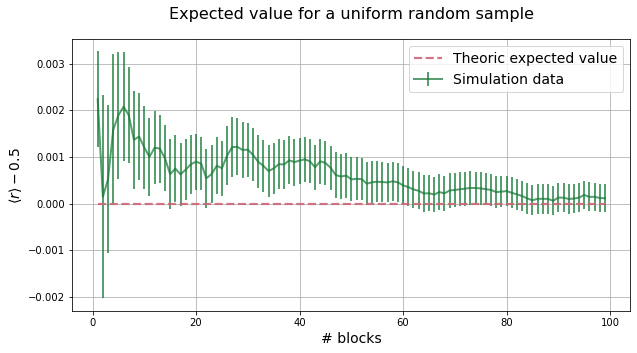

In [42]:
plt.figure(figsize=(10,5))
plt.title("Expected value for a uniform random sample",fontsize=16,pad=20)
plt.errorbar(x, measurements.T[0]-0.5, yerr=measurements.T[1], color='#117733', alpha=0.7, label='Simulation data', linewidth=2)
plt.hlines(0,1,N-1, color='#CC6677', linestyle='--', label="Theoric expected value", linewidth=2.2, alpha=0.9)
plt.ylabel(r'$\langle r \rangle- 0.5$',fontsize=14)
plt.xlabel("# blocks",fontsize=14)
plt.legend(fontsize=14)
plt.grid(True)
plt.show()

N.B.: La misura del blocco zero non viene plottata essendo quest'ultima priva di incertezza statistica, dato che statisticamente rappresenta una misura singola e non una media tra misure. Tolto questo specifico dato, il numero totale di misure è 99 e non 100.

**B)** Come seconda parte del primo esercizio vogliamo calcolare la varianza della media, ossia la stima $\langle (r-1/2)^2 \rangle$ dove $r$ rappresenta, come nell'esercizio precedente, una variabile casuale con distribuzione di probabilità uniforme nell'intervallo $[0,1)$:
$$\sigma^2 = \int_0^1 (r-1/2)^2 dr = 1/12$$

La differenza tra il risultato della simulazione e il valore effettivo di aspettazione ($1/12$) viene plottata con la sua incertezza statistica per un numero crescente di blocchi (da 1 fino a 100), come  mostrato qui di seguito. Possiamo osservare anche in questo caso come le barre d'errore tendano ad accorciarsi al crescere del numero dei blocchi e il valore risultante medio finale è compatibile con il valore di aspettazione.

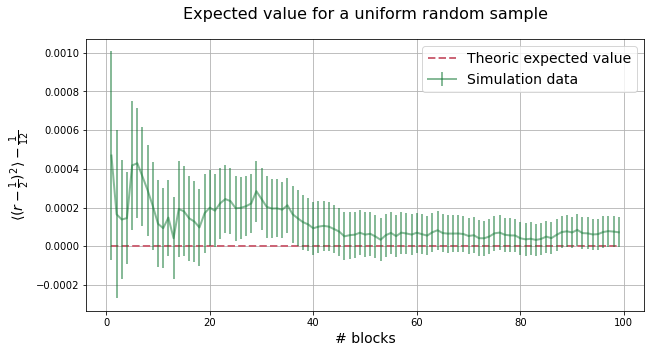

In [43]:
plt.figure(figsize=(10,5))
plt.title("Expected value for a uniform random sample",fontsize=16, pad=20)
plt.hlines(0,1,N-1, color='#CC6677', linestyle='--', label="Theoric expected value", linewidth=2, alpha=1)
plt.errorbar(x,measurements1.T[0]-1/12,yerr=measurements1.T[1],color='#117733', alpha=0.5, label='Simulation data', linewidth=2)
plt.xlabel('# blocks',fontsize=14)
plt.ylabel(r'$ \langle (r-\frac{1}{2})^{2} \rangle - \frac{1}{12} $',fontsize=14)
plt.legend(fontsize=14)
plt.grid(True)

plt.show()

**C)** Proviamo ora ad ipotizzare che i numeri pseudo-casuali generati dal generatore `Rannyu()` non siano estratti da una distribuzione uniforme. Implementiamo dunque il test di verifica di ipotesi del $\chi^2$, che ci permette di rifiutare/non rifiutare tale ipotesi.

Abbiamo generato $10^4$ numeri pseudo-casuali uniformi nell'intervallo $[0,1)$ e abbiamo contato (mediante un ciclo che individua in quale sotto-intervallo cade ogni numero) quanti eventi $n_i$ si ottengono per ogni sotto intervallo. Questo test viene effettuato per $100$ volte e il risultato per ogni test è la quantità esplicitata dalla formula seguente:
$${\chi_j}^2 = \sum_{i=1}^M \frac{\left( n_i - n/M \right)^2}{n/M}\,\,\text{per}\,\,j=0,..,99$$

Come mostrato nella figura seguente i diversi ${\chi_j}^2$ si distribuiscono intorno al valore $100$ con i picchi più alti di $140$ e quelli più bassi intorno a $70$.

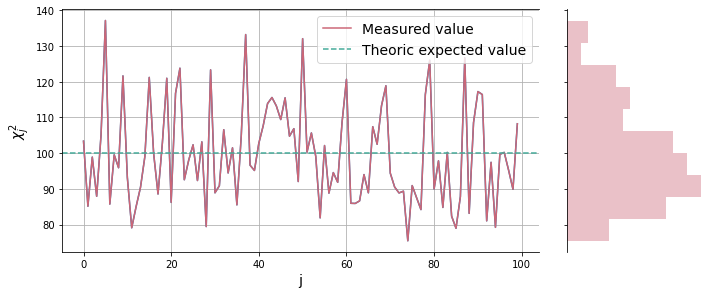

In [7]:
appo=0
for i in range(len(chi)):
    appo += chi[i]
appo /= len(chi)

x = np.arange(0,100,1)
y = chi
ynoise= y
y_sorted=np.sort(y)

grid = sns.JointGrid(x, ynoise, ratio=3)
grid.plot_joint(plt.plot)
grid.ax_joint.plot(x, y, c='#CC6677',label='Measured value')
grid.ax_joint.axhline(100,linestyle='--',label = 'Theoric expected value', color='#44AA99')
plt.sca(grid.ax_marg_y)
sns.distplot(grid.y, kde=False, vertical=True, bins=10,color='#CC6677')

grid.set_axis_labels('j', r'$\chi_{j}^2$', fontsize=14)
grid.fig.set_size_inches(10,5)
grid.ax_marg_x.remove()
grid.ax_joint.spines['top'].set_visible(True)
grid.ax_joint.legend( fontsize=14)
grid.ax_joint.grid(True)

Ora siamo interessati a svolgere un'analisi più rigorosa. Aumentiamo il numero di realizzazioni di ${\chi_j}^2$ al fine di vedere come si distribuiscono. Effettuiamo il test svolto sopra $10^4$ volte.

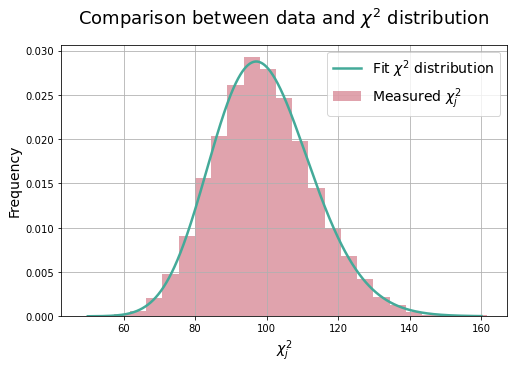

In [37]:
y = chi_distrib
x = np.linspace(50, 160, 10000)
fit_chi = stats.chi2.fit(y)
chi = stats.chi2.pdf(x, fit_chi[0], fit_chi[1], fit_chi[2])
#print("Mean value: ", fit_chi[0])
################################################################
hist_chi = stats.chi2(100)
plt.figure(figsize=(8,5))
plt.title('Comparison between data and $\chi^2$ distribution',fontsize=18,pad=20)
plt.hist(chi_distrib,density=True,color='#CC6677',bins=25,alpha=0.6,label='Measured $\chi_j^2$')
plt.plot(x,chi,color='#44AA99',linewidth=2.5,label='Fit $\chi^2$ distribution')
plt.grid(True)
plt.legend(fontsize=14)
plt.xlabel(r'$\chi_{j}^2$',fontsize=14)
plt.ylabel('Frequency',fontsize=14)
plt.show()

Possiamo vedere come se effettuiamo un fit $\chi^2$ sulle variabili ${\chi_j}^2$ ottenute (come mostrato in figura), il fit interpola i dati a disposizione in modo qualitativamente soddisfacente. Inoltre, osservando il primo parametro del fit, ossia la media dei dati, scopriamo che $\langle\chi^2\rangle \simeq 91.2$.
Questi risultati ci portano a concludere che l'ipotesi che questo generatore di numeri pseudo-casuali non sia un buon generatore è piuttosto improbabile.

### Esercizio 2

L'obiettivo di questo secondo esercizio è quello di verificare la validità del Teorema del Limite Centrale (TLC).
A tal proposito vengono generati e mediati per $10^{4}$ volte $N=1,2,10,100$ numeri casuali estratti dalle seguenti tre distribuzioni:

1. distribuzione uniforme in $[0,1]$;
2. distribuzione esponenziale  $p(x) = \lambda \exp(-\lambda x)\,\,\,\text{per}\,\,x\in [0;+\infty]\,\,\text{e}\,\,\lambda=1$;
3. distribuzione di Cauchy-Lorentz  $p(x)=\frac{1}{\pi}\frac{\Gamma}{(x-\mu)^2+\Gamma^2}\,\,\text{per}\,\,x\in [-\infty;+\infty]\,\,,\,\,\mu=0\,\,\text{e}\,\,\Gamma=1$;

Osserviamo che per estrarre numeri casuali dalle distribuzioni $2$ e $3$ abbiamo utilizzato il metodo dell'*inversione della cumulativa*. Se è nota $p_{x}(x)$ e $y=y(x)$ continua e non decrescente in $x$, allora la p.d.f di y può essere trovata come: $p_{y}(y)=p_{x}(x)\cdot\big{|}\frac{dy}{dx}\big{|}^{-1}$
e nel caso in cui $y=F_{x}(x)$ allora $p_{y}(y)=p_{x}(x)\cdot\big{|}\frac{dy}{dx}\big{|}^{-1}= p_{x}(x)\cdot(p_{x}(x))^{-1}=1$.
Questo metodo ci permette dunque di estrarre un numero casuale da una distribuzione $p_{x}(x)$ generica a partire da un numero casuale estratto da una distribuzione uniforme in $[0,1]$ a patto che la CDF di $x$ sia invertibile. Se ciò è possibile abbiamo che $x=F^{-1}(y)$ con $y\in[0,1]$ uniforme.


Partiamo dalla distribuzione esponenziale.

$$p(x) = \lambda \exp(-\lambda x)\,\,\,\text{con}\,\,\, x\in [0;+\infty]$$

$$F(x)=\int_{0}^{x} \lambda\exp(-\lambda x')dx'=1-\exp(-\lambda x)$$

$$x=F^{-1}(y) \Rightarrow x=-\frac{1}{\lambda}\ln(1-y)$$

Analogamente vale nel caso della distribuzione di Cauchy-Lorentz:


$$p(x)=\frac{1}{\pi}\frac{\Gamma}{(x-\mu)^2+\Gamma^2}\,\,\,\text{con}\,\,\,x\in [-\infty;+\infty]$$

$$F(x)=\int_{-\infty}^{x} \frac{1}{\pi}\frac{\Gamma}{(x'-\mu)^2+\Gamma^2}dx'=\frac{1}{\pi}\tan^{-1}\big(\frac{x-\mu}{\Gamma}\big)$$

$$x=F^{-1}(y) \Rightarrow x=\mu+\Gamma \tan\bigg(\pi\big(y-\frac{1}{2}\big)\bigg)$$

Qui di seguito sono riportati i grafici seguendo l'ordine sopra delle distribuzioni con i relativi fit in corrispondenza degli istogrammi per $N=100$.

In [4]:
tlc = np.loadtxt("tlc.dat")
tlc1 = np.loadtxt("tlc1.dat")
tlc2 = np.loadtxt("tlc2.dat")
tlc3 = np.loadtxt("tlc3.dat")

#Fit
x = np.linspace(-10, 10, 10000)
fit_unif = stats.norm.fit(tlc3.T[0])
fit_exp = stats.norm.fit(tlc3.T[1])
fit_cauchy = stats.cauchy.fit(tlc3.T[2])
unif = stats.norm.pdf(x, fit_unif[0], fit_unif[1])
exp = stats.norm.pdf(x, fit_exp[0], fit_exp[1])
cauchy = stats.cauchy.pdf(x, fit_cauchy[0], fit_cauchy[1])

**Distribuzione uniforme in $[0,1]$**:

Si può osservare che le variabili random per $N$ piccolo seguono una distribuzione uniforme e, all'aumentare di $N$, tendono a distribuirsi secondo una Gaussiana. 

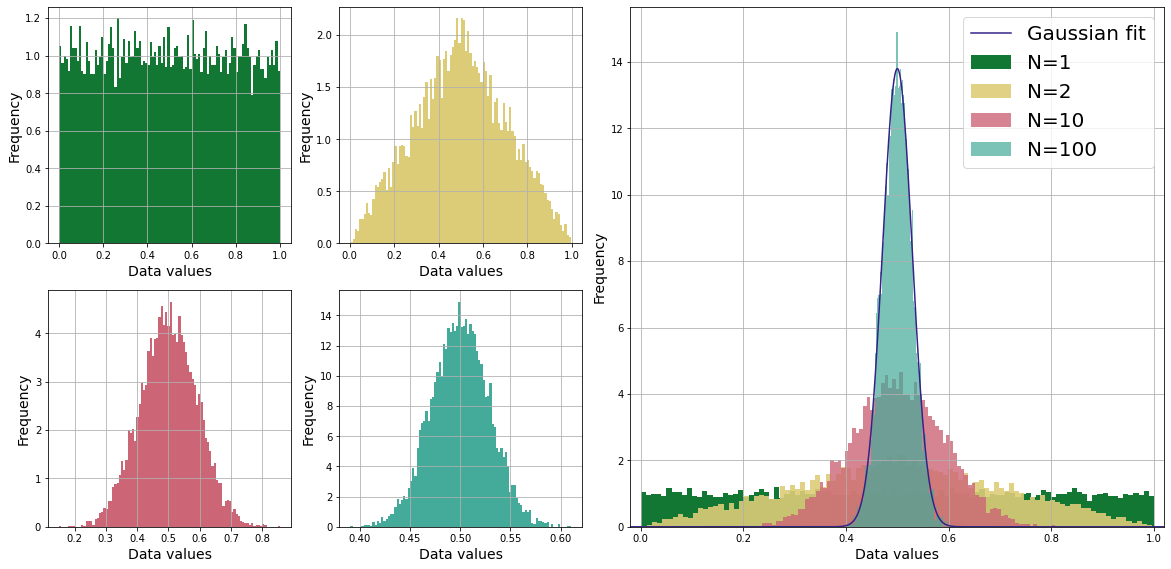

In [16]:
plt.figure(figsize=(20,20))
gridspec.GridSpec(4,4)

# large subplot
plt.subplot2grid((4,4), (0,2), colspan=2, rowspan=2)
plt.xlabel('Data values',fontsize=14)
plt.ylabel('Frequency',fontsize=14)
plt.hist(tlc.T[0],bins=100, color='#117733', alpha=1,density=True, label='N=1')
plt.hist(tlc1.T[0],bins=100, color='#DDCC77', alpha=0.9,density=True, label='N=2')
plt.hist(tlc2.T[0],bins=100, color='#CC6677', alpha=0.8,density=True, label='N=10')
plt.hist(tlc3.T[0],bins=100, color='#44AA99', alpha=0.7,density=True, label='N=100')
plt.plot(x,unif,color='#332288',lw=1.5,alpha=1,label='Gaussian fit')
plt.xlim(-0.02,1.02)
plt.legend(fontsize=20)
plt.grid(True)

# small subplot 1
plt.subplot2grid((4,4), (0,0))
plt.xlabel('Data values',fontsize=14)
plt.ylabel('Frequency',fontsize=14)
plt.hist(tlc.T[0],bins=100, color='#117733', alpha=1,density=True)
plt.grid(True)

# small subplot 2
plt.subplot2grid((4,4), (0,1))
plt.xlabel('Data values',fontsize=14)
plt.ylabel('Frequency',fontsize=14)
plt.hist(tlc1.T[0],bins=100, color='#DDCC77', alpha=1,density=True)
plt.grid(True)

# small subplot 3
plt.subplot2grid((4,4), (1,0))
plt.xlabel('Data values',fontsize=14)
plt.ylabel('Frequency',fontsize=14)
plt.hist(tlc2.T[0],bins=100, color='#CC6677', alpha=1,density=True)
plt.grid(True)

# small subplot 4
plt.subplot2grid((4,4), (1,1))
plt.xlabel('Data values',fontsize=14)
plt.ylabel('Frequency',fontsize=14)
plt.hist(tlc3.T[0],bins=100, color='#44AA99', alpha=1,density=True)
plt.grid(True)

plt.show()

**Distribuzione esponenziale**:

Si può osservare che le variabili random per $N$ piccolo seguono una distribuzione esponenziale e, all'aumentare di $N$, tendono a distribuirsi anche in questo caso secondo una Gaussiana. 

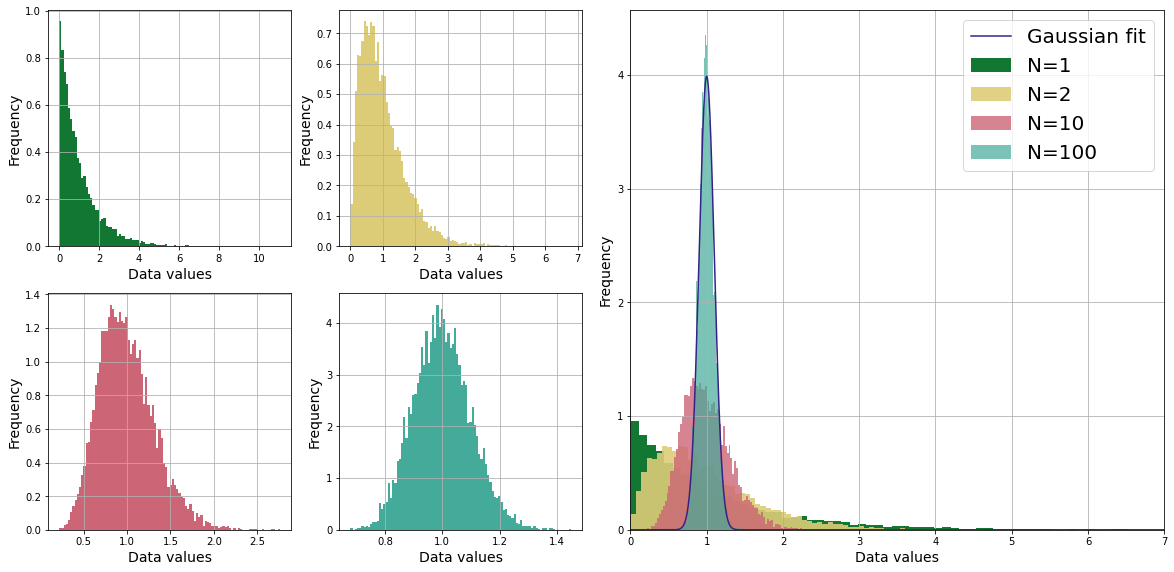

In [17]:
plt.figure(figsize=(20,20))
gridspec.GridSpec(4,4)

# large subplot
plt.subplot2grid((4,4), (0,2), colspan=2, rowspan=2)
plt.xlabel('Data values',fontsize=14)
plt.ylabel('Frequency',fontsize=14)
plt.hist(tlc.T[1],bins=100, color='#117733', alpha=1,density=True, label='N=1')
plt.hist(tlc1.T[1],bins=100, color='#DDCC77', alpha=0.9,density=True, label='N=2')
plt.hist(tlc2.T[1],bins=100, color='#CC6677', alpha=0.8,density=True, label='N=10')
plt.hist(tlc3.T[1],bins=100, color='#44AA99', alpha=0.7,density=True, label='N=100')
plt.plot(x,exp,color='#332288',alpha=1,lw=1.5,label='Gaussian fit')
plt.xlim(0,7)
plt.legend(fontsize=20)
plt.grid(True)

# small subplot 1
plt.subplot2grid((4,4), (0,0))
plt.xlabel('Data values',fontsize=14)
plt.ylabel('Frequency',fontsize=14)
plt.hist(tlc.T[1],bins=100, color='#117733', alpha=1,density=True)
plt.grid(True)

# small subplot 2
plt.subplot2grid((4,4), (0,1))
plt.xlabel('Data values',fontsize=14)
plt.ylabel('Frequency',fontsize=14)
plt.hist(tlc1.T[1],bins=100, color='#DDCC77', alpha=1,density=True)
plt.grid(True)

# small subplot 3
plt.subplot2grid((4,4), (1,0))
plt.xlabel('Data values',fontsize=14)
plt.ylabel('Frequency',fontsize=14)
plt.hist(tlc2.T[1],bins=100, color='#CC6677', alpha=1,density=True)
plt.grid(True)

# small subplot 4
plt.subplot2grid((4,4), (1,1))
plt.xlabel('Data values',fontsize=14)
plt.ylabel('Frequency',fontsize=14)
plt.hist(tlc3.T[1],bins=100, color='#44AA99', alpha=1,density=True)
plt.grid(True)

plt.show()

**Distribuzione di Cauchy-Lorentz**:

In questo caso le variabili random, indipendentemente dal valore di $N$, si distribuiscono sempre secondo la distribuzione di Cauchy-Lorentz. Questo fatto non deve sorprenderci essendo che la distribuzione di Cauchy-Lorentz ha varianza infinita e quindi non rispetta le ipotesi del TLC. Rimane importante da sottolineare il fatto che la distribuzione di Cauchy-Lorentz rimane sempre la stessa al variare di $N$ poichè è stabile e quindi è essa stessa il proprio attrattore nello spazio delle distribuzioni.

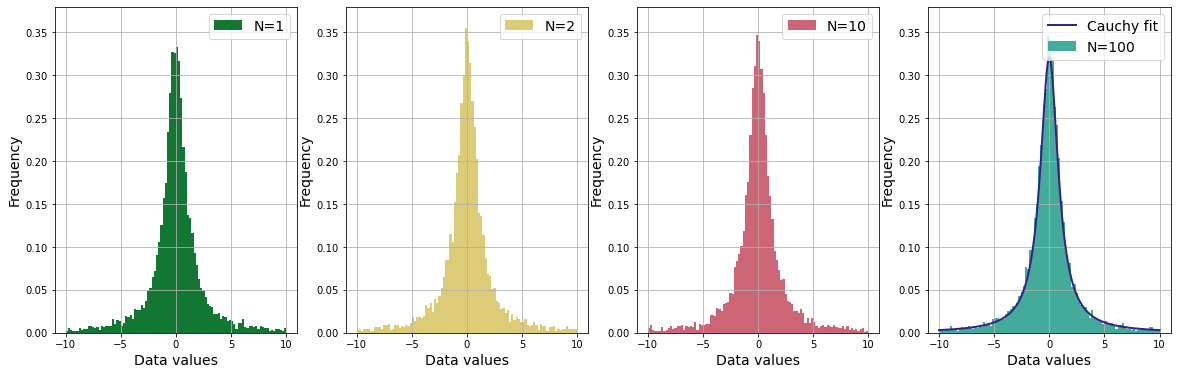

In [20]:
plt.figure(figsize=(20,6))

# small subplot 1
plt.subplot(1,4,1)
plt.xlabel('Data values',fontsize=14)
plt.ylabel('Frequency',fontsize=14)
plt.hist(tlc.T[2],bins=100, color='#117733', alpha=1,density=True, range=(-10,10),label='N=1')
plt.grid(True)
plt.legend(fontsize=14)
plt.ylim(0,0.38)

# small subplot 2
plt.subplot(1,4,2)
plt.xlabel('Data values',fontsize=14)
plt.ylabel('Frequency',fontsize=14)
plt.hist(tlc1.T[2],bins=100, color='#DDCC77', alpha=1,density=True,range=(-10,10),label='N=2')
plt.grid(True)
plt.legend(fontsize=14)
plt.ylim(0,0.38)

# small subplot 3
plt.subplot(1,4,3)
plt.xlabel('Data values',fontsize=14)
plt.ylabel('Frequency',fontsize=14)
plt.hist(tlc2.T[2],bins=100, color='#CC6677', alpha=1,density=True,range=(-10,10),label='N=10')
plt.grid(True)
plt.legend(fontsize=14)
plt.ylim(0,0.38)

# small subplot 4
plt.subplot(1,4,4)
plt.xlabel('Data values',fontsize=14)
plt.ylabel('Frequency',fontsize=14)
plt.hist(tlc3.T[2],bins=100, color='#44AA99', alpha=1,density=True,range=(-10,10),label='N=100')
plt.plot(x,cauchy,color='#332288',lw=2,alpha=1,label='Cauchy fit')
plt.grid(True)
plt.legend(fontsize=14)
plt.ylim(0,0.38)

plt.show()

### Esercizio 3

L'obiettivo di questo esercizio è simulare l'esperimento di Buffon al fine di stimare il valore di $\pi$.
L'esperimento consiste nel lanciare un ago di lunghezza $L$ casualmente su un piano orizzontale, quest'ultimo suddiviso da linee rette equidistanti $d$ ($d > L$).
Poichè la probabilità che l'ago intersechi una di queste linee è $P=\frac{2L}{\pi d}$, se l'ago viene lanciato $N_{throws}$ volte e colpisce una linea $N_{hit}$ di quelle volte, possiamo stimare il valore di $\pi$ attraverso questa formula: 

$$\pi = \frac{2L}{Pd} = \lim_{N_{throws} \to \infty}\frac{2LN_{throws}}{N_{hit}d}$$

Per simulare il lancio casuale dell'ago, inizialmente viene generata la posizione bidimensionale di uno dei due vertici in modo casuale. Successivamente viene estratta uniformemente la posizione del secondo vertice a distanza $L$, generando un angolo $\theta \in [0,2\pi]$. Notiamo però che così facendo il rischio è quello di stimare $\pi$ usando il suo valore esatto durante la simulazione. In realtà, onde evitare questo imbroglio, il valore di pi greco viene stimato con un metodo Monte Carlo, producendo punti che casualmente si dispongono in un quadrato. 
Il rapporto tra l'area dell'arco del cerchio circoscritto e l'area del quadrato è $\pi/4$. Per questo motivo, moltiplicando per 4 il rapporto tra il numero di punti generati all'interno dell'arco e il numero di punti totali si trova una stima di $\pi$.
Una volta identificata nel piano la direzione e la posizione dell'ago, vengono effettuati i tentativi di lancio che possono accrescere $N_{hit}$ a seconda che l'ago intersechi una linea del piano.

Attraverso il metodo data-blocking ($10^4$ misure suddivise in $100$ blocchi) stimiamo il valore medio di $\frac{2LN_{throws}}{N_{hit}d}$ e la sua incertezza statistica assegnando prima i valori ai parametri $L$ e $d$: $L=0.05$ e $d=0.1$.
La simulazione mostra una buona compatibilità con il valore vero di $\pi$ al crescere del numero dei tiri $N_{throws}$.

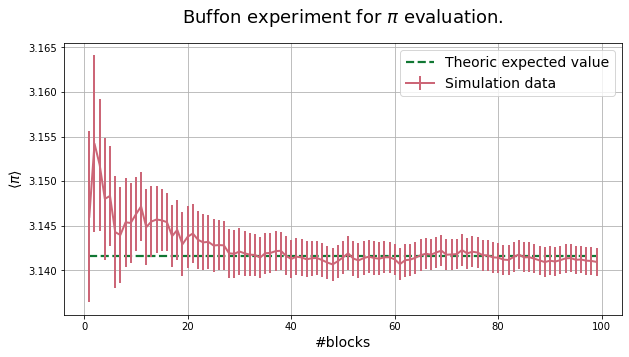

In [44]:
buffon= np.loadtxt("Buffon_Experiment.dat")
x = np.arange(1,100,1)

plt.figure(figsize=(10,5))
plt.title("Buffon experiment for $\pi$ evaluation.",fontsize=18, pad=20)
plt.hlines(np.pi,1,99, color='#117733', linestyle='--', label="Theoric expected value", linewidth=2.2, alpha=1)
plt.errorbar(x,buffon.T[0],yerr=buffon.T[1],color='#CC6677', alpha=1, label='Simulation data', linewidth=2)
plt.xlabel('#blocks',fontsize=14)
plt.ylabel(r'$\langle\pi \rangle$',fontsize=14)
plt.legend(fontsize=14)
plt.grid(True)
plt.show()